# **import ucf101 dataset**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

**if use TPU**

In [2]:
!pip install opencv-python-headless
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 MB 584.6 kB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 17.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 5.0 MB/s eta 0:00:0000:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


# Import packages

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
import numpy as np
from tqdm import tqdm
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.utils import to_categorical
import itertools
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow import keras

# Import Label File

In [4]:
label_data = pd.read_csv("../input/ucf101/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/classInd.txt", sep=' ', header=None)
label_data.columns=['index', 'labels']
label_data = label_data.drop(['index'], axis=1)
label_data

,labels
0,ApplyEyeMakeup
1,ApplyLipstick
2,Archery
3,BabyCrawling
4,BalanceBeam
...,...
96,VolleyballSpiking
97,WalkingWithDog
98,WallPushups
99,WritingOnBoard


In [5]:
#Number of classes
len(label_data)

101

# Setting path For data

In [6]:
path=[]
for label in label_data.labels.values:
    path.append('../input/ucf101/UCF101/UCF-101/'+label+"/")
path[0]

'../input/ucf101/UCF101/UCF-101/ApplyEyeMakeup/'

# Data Preperation

In [7]:
#Function for Feature Extraction
def feature_extraction(video_path):
    width=60
    height=60
    sequence_length=10
    frames_list=[]
    #Read the Video
    video_reader = cv2.VideoCapture(video_path)
    #get the frame count
    frame_count=int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    #Calculate the interval after which frames will be added to the list
    skip_interval = max(int(frame_count/sequence_length), 1)
    #iterate through video frames
    for counter in range(sequence_length):
        #Set the current frame postion of the video
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, counter * skip_interval)
        #Read the current frame 
        ret, frame = video_reader.read()
        if not ret:
            break;
        #Resize the image
        frame=cv2.resize(frame, (height, width))
        frame = frame/255
        #Append to the frame
        frames_list.append(frame)
    video_reader.release()
    #Return the Frames List
    return frames_list

The below function is used for extracting features from a video file. It takes in the path of the video file as input and returns a list of frames from the video.

The function first reads the video using the cv2.VideoCapture method. It then calculates the total number of frames in the video using the cv2.CAP_PROP_FRAME_COUNT property. Next, it calculates the interval after which frames will be added to the list by dividing the total number of frames by the desired sequence length. This is done to ensure that we only extract a certain number of frames from the video.

The function then iterates through the video frames and sets the current frame position using the cv2.CAP_PROP_POS_FRAMES property. It then reads the current frame and resizes it to a desired width and height using the cv2.resize method. The frame is then normalized by dividing it by 255. Finally, the frame is appended to the frames_list.

Once all the desired frames have been extracted, the function releases the video reader and returns the frames_list.

For example, if we pass a video file with 100 frames and a sequence length of 10 to this function, it will extract frames at intervals of 10 (0th, 10th, 20th, ... 90th frame) and return a list of 10 frames.


Why we need sequence length?
Sequence length is the number of frames that we want to extract from a video file. It is an important parameter in feature extraction as it determines the number of frames that will be used to represent the video.

There are several reasons why we might want to specify a particular sequence length:

Memory Constraints: Extracting all the frames from a video file can be computationally expensive and may not be feasible if we have limited memory or processing power. By specifying a sequence length, we can reduce the number of frames that need to be processed and stored in memory, making the feature extraction process more efficient.

Length of Video: Some videos may be very long and contain thousands of frames. In such cases, it may not be necessary or practical to extract all the frames for feature extraction. By specifying a sequence length, we can reduce the number of frames that need to be processed, making the feature extraction process more efficient.

Relevance of Frames: Not all frames in a video may be relevant for feature extraction. By specifying a sequence length, we can ensure that only the most relevant frames are extracted, which can improve the quality of the features.

Overall, sequence length is an important parameter in feature extraction as it helps us to balance the trade-off between the amount of information extracted from the video and the computational resources required to process it.






In [8]:
#Function for loading video files, Process and store in a data set
def load_video(datasets):
    global image
    label_index=0
    labels=[]
    images=[]
    #Iterate through each foler corresponding to category
    for folder in datasets:
        print(label_index)
        for file in tqdm(os.listdir(folder)):
            #Get the path name for each video
            video_path = os.path.join(folder, file)
            #Extract the frames of the current video
            frames_list = feature_extraction(video_path)
            images.append(frames_list)
            labels.append(label_index)
        label_index+=1
    return np.array(images, dtype='float16'), np.array(labels, dtype='int8')

The above function is used to load and process video files and store them in a dataset. It takes in a list of datasets (folders containing video files) as input and returns a tuple of images (a numpy array of extracted frames) and labels (a numpy array of label indices).

The function first initializes two empty lists: labels and images. It then iterates through each folder in the datasets list, which corresponds to a particular category of videos. For each folder, it iterates through all the video files and gets the path name of each video using the os.path.join method.

It then calls the feature_extraction function to extract the frames of the current video and stores the resulting list in the images list. It also appends the label index (which corresponds to the category of the video) to the labels list.

Once all the videos have been processed, the function returns the images and labels as a tuple.

For example, if we pass a list of two datasets (folders) containing 10 video files each to this function, it will extract the frames from all 20 videos, store them in the images list, and append the corresponding label indices (0 or 1) to the labels list. It will then return a tuple of numpy arrays containing the extracted frames and the label indices.

# **prepare the dataset for training**

In [10]:

images, labels = load_video(path[:100])

np.save('/kaggle/working/images',images)
np.save('/kaggle/working/labels',labels)

0


100%|██████████| 145/145 [00:39<00:00,  3.70it/s]


1


100%|██████████| 114/114 [00:26<00:00,  4.26it/s]


2


100%|██████████| 145/145 [00:32<00:00,  4.48it/s]


3


100%|██████████| 132/132 [00:37<00:00,  3.50it/s]


4


100%|██████████| 108/108 [00:25<00:00,  4.23it/s]


5


100%|██████████| 155/155 [00:48<00:00,  3.20it/s]


6


100%|██████████| 150/150 [00:09<00:00, 15.70it/s]


7


100%|██████████| 134/134 [00:08<00:00, 15.26it/s]


8


100%|██████████| 131/131 [00:10<00:00, 12.23it/s]


9


100%|██████████| 160/160 [00:10<00:00, 15.57it/s]


10


100%|██████████| 134/134 [00:08<00:00, 16.34it/s]


11


100%|██████████| 150/150 [00:09<00:00, 15.74it/s]


12


100%|██████████| 131/131 [00:29<00:00,  4.38it/s]


13


100%|██████████| 109/109 [00:19<00:00,  5.61it/s]


14


100%|██████████| 112/112 [00:12<00:00,  8.68it/s]


15


100%|██████████| 155/155 [00:32<00:00,  4.71it/s]


16


100%|██████████| 163/163 [00:23<00:00,  7.05it/s]


17


100%|██████████| 134/134 [00:51<00:00,  2.61it/s]


18


100%|██████████| 101/101 [00:06<00:00, 16.10it/s]


19


100%|██████████| 131/131 [00:21<00:00,  6.03it/s]


20


100%|██████████| 112/112 [00:07<00:00, 15.96it/s]


21


100%|██████████| 138/138 [00:12<00:00, 11.11it/s]


22


100%|██████████| 139/139 [00:13<00:00, 10.22it/s]


23


100%|██████████| 167/167 [00:15<00:00, 10.86it/s]


24


100%|██████████| 110/110 [00:16<00:00,  6.75it/s]


25


100%|██████████| 150/150 [00:09<00:00, 15.40it/s]


26


100%|██████████| 161/161 [00:10<00:00, 15.85it/s]


27


100%|██████████| 111/111 [00:06<00:00, 15.93it/s]


28


100%|██████████| 126/126 [00:14<00:00,  8.48it/s]


29


100%|██████████| 125/125 [00:17<00:00,  7.02it/s]


30


100%|██████████| 126/126 [00:11<00:00, 10.53it/s]


31


100%|██████████| 137/137 [00:17<00:00,  7.86it/s]


32


100%|██████████| 139/139 [00:08<00:00, 15.97it/s]


33


100%|██████████| 130/130 [00:20<00:00,  6.43it/s]


34


100%|██████████| 140/140 [00:31<00:00,  4.44it/s]


35


100%|██████████| 150/150 [00:21<00:00,  6.97it/s]


36


100%|██████████| 128/128 [00:27<00:00,  4.64it/s]


37


100%|██████████| 111/111 [00:13<00:00,  7.96it/s]


38


100%|██████████| 147/147 [00:20<00:00,  7.04it/s]


39


100%|██████████| 123/123 [00:07<00:00, 15.39it/s]


40


100%|██████████| 124/124 [00:07<00:00, 16.01it/s]


41


100%|██████████| 164/164 [00:10<00:00, 15.14it/s]


42


100%|██████████| 125/125 [00:07<00:00, 15.69it/s]


43


100%|██████████| 158/158 [00:28<00:00,  5.52it/s]


44


100%|██████████| 117/117 [00:07<00:00, 16.52it/s]


45


100%|██████████| 121/121 [00:08<00:00, 14.84it/s]


46


100%|██████████| 123/123 [00:07<00:00, 15.61it/s]


47


100%|██████████| 144/144 [00:09<00:00, 15.61it/s]


48


100%|██████████| 141/141 [00:09<00:00, 15.23it/s]


49


100%|██████████| 123/123 [00:23<00:00,  5.32it/s]


50


100%|██████████| 131/131 [00:22<00:00,  5.95it/s]


51


100%|██████████| 127/127 [00:08<00:00, 15.35it/s]


52


100%|██████████| 125/125 [00:08<00:00, 15.29it/s]


53


100%|██████████| 136/136 [00:08<00:00, 15.31it/s]


54


100%|██████████| 110/110 [00:16<00:00,  6.50it/s]


55


100%|██████████| 132/132 [00:08<00:00, 15.50it/s]


56


100%|██████████| 114/114 [00:14<00:00,  7.78it/s]


57


100%|██████████| 113/113 [00:07<00:00, 15.79it/s]


58


100%|██████████| 164/164 [00:28<00:00,  5.71it/s]


59


100%|██████████| 151/151 [00:28<00:00,  5.34it/s]


60


100%|██████████| 164/164 [00:31<00:00,  5.24it/s]


61


100%|██████████| 155/155 [00:54<00:00,  2.82it/s]


62


100%|██████████| 160/160 [00:11<00:00, 14.52it/s]


63


100%|██████████| 105/105 [00:07<00:00, 14.44it/s]


64


100%|██████████| 157/157 [00:29<00:00,  5.35it/s]


65


100%|██████████| 111/111 [00:07<00:00, 14.90it/s]


66


100%|██████████| 100/100 [00:06<00:00, 14.48it/s]


67


100%|██████████| 149/149 [00:10<00:00, 14.65it/s]


68


100%|██████████| 123/123 [00:11<00:00, 10.65it/s]


69


100%|██████████| 100/100 [00:06<00:00, 15.07it/s]


70


100%|██████████| 160/160 [00:11<00:00, 14.50it/s]


71


100%|██████████| 102/102 [00:06<00:00, 15.10it/s]


72


100%|██████████| 111/111 [00:23<00:00,  4.73it/s]


73


100%|██████████| 144/144 [00:10<00:00, 14.18it/s]


74


100%|██████████| 119/119 [00:07<00:00, 15.19it/s]


75


100%|██████████| 137/137 [00:09<00:00, 14.11it/s]


76


100%|██████████| 133/133 [00:09<00:00, 14.60it/s]


77


100%|██████████| 161/161 [00:30<00:00,  5.28it/s]


78


100%|██████████| 144/144 [00:19<00:00,  7.29it/s]


79


100%|██████████| 120/120 [00:08<00:00, 14.69it/s]


80


100%|██████████| 135/135 [00:09<00:00, 14.57it/s]


81


100%|██████████| 100/100 [00:06<00:00, 14.87it/s]


82


100%|██████████| 110/110 [00:18<00:00,  6.03it/s]


83


100%|██████████| 147/147 [00:10<00:00, 14.34it/s]


84


100%|██████████| 137/137 [00:14<00:00,  9.57it/s]


85


100%|██████████| 112/112 [00:19<00:00,  5.73it/s]


86


100%|██████████| 116/116 [00:27<00:00,  4.21it/s]


87


100%|██████████| 126/126 [00:23<00:00,  5.25it/s]


88


100%|██████████| 131/131 [00:09<00:00, 14.31it/s]


89


100%|██████████| 140/140 [00:39<00:00,  3.55it/s]


90


100%|██████████| 100/100 [00:06<00:00, 14.52it/s]


91


100%|██████████| 166/166 [00:10<00:00, 15.36it/s]


92


100%|██████████| 130/130 [00:08<00:00, 14.77it/s]


93


100%|██████████| 119/119 [00:08<00:00, 14.39it/s]


94


100%|██████████| 136/136 [00:26<00:00,  5.15it/s]


95


100%|██████████| 104/104 [00:17<00:00,  5.97it/s]


96


100%|██████████| 116/116 [00:07<00:00, 15.21it/s]


97


100%|██████████| 123/123 [00:08<00:00, 14.28it/s]


98


100%|██████████| 130/130 [00:18<00:00,  6.90it/s]


99


100%|██████████| 152/152 [00:37<00:00,  4.01it/s]


# Load dataset

In [9]:
images=np.load('/kaggle/working/images.npy')
labels=np.load('/kaggle/working/labels.npy')

In [10]:
images[0].shape

(10, 60, 60, 3)

# **Train Test Split**

In [11]:
x_train, x_test, y_train, y_test=train_test_split(images, labels, test_size=0.06, random_state=10)
x_train.shape, x_test.shape, np.array(y_train).shape, np.array(y_test).shape

((12400, 10, 60, 60, 3), (792, 10, 60, 60, 3), (12400,), (792,))

## The Proposal model: CNN + LSTM (ConvLSTM2D)

In [13]:
model = Sequential()

model.add(BatchNormalization(momentum=0.8, input_shape=(x_train.shape[1],x_train.shape[2], x_train.shape[3], 3)))
model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.3)))

model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.3)))

model.add(Flatten())

model.add(Dense(4096,activation="relu"))
    
model.add(Dense(100, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Batc  (None, 10, 60, 60, 3)    12        
 hNormalization)                                                 
                                                                 
 conv_lstm2d_4 (ConvLSTM2D)  (None, 10, 58, 58, 16)    11008     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 29, 29, 16)   0         
 3D)                                                             
                                                                 
 time_distributed_4 (TimeDis  (None, 10, 29, 29, 16)   0         
 tributed)                                                       
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, 10, 27, 27, 16)    18496     
                                                      

The above code defines a Convolutional Long Short-Term Memory (ConvLSTM) model for video classification. It consists of several layers of ConvLSTM2D, MaxPooling3D, Dropout, BatchNormalization, and Dense layers.

The input to the model is a sequence of video frames with shape (batch_size, sequence_length, height, width, channels). The first layer is a BatchNormalization layer, which normalizes the input data using the mean and standard deviation of the batch.

The next several layers are ConvLSTM2D layers, which are a type of convolutional neural network (CNN) layer that has memory cells to process sequential data. These layers apply convolutional filters to the input data and use the LSTM algorithm to process the sequential information. The kernel_size parameter specifies the size of the convolutional filters, and the activation parameter specifies the activation function to be used. The return_sequences parameter specifies whether the output of the layer should be returned as a sequence or as a single step output. The recurrent_dropout parameter specifies the dropout rate for the recurrent connections in the layer.

The MaxPooling3D layers are used to down-sample the input data by taking the maximum value over a pooling window of a specified size. The padding parameter specifies whether the input data should be padded before applying the pooling operation.

The TimeDistributed layers are used to apply a layer to each step of a sequence independently. The Dropout layers are used to randomly set a fraction of the input units to 0 at each update during training, which helps to prevent overfitting.

The BatchNormalization layers are used to normalize the activations of the previous layers using the mean and standard deviation of the batch.

Finally, the model has a Flatten layer to flatten the output of the previous layer, followed by two Dense layers. The first dense layer has 4096 units and uses the ReLU activation function. The second dense layer has 9 units and uses the softmax activation function, which is suitable for classification tasks. The model summary is then printed to show the details of the model.

For example, if we pass a batch of 8 video sequences with each sequence having a length of 10 frames and dimensions of 60x60x3 to this model, it will process the data through the various layers and output a prediction for each video sequence, with each prediction being a probability distribution over the 9 possible classes./'

In [14]:
#compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

#load the pretrained model
model = keras.models.load_model('/kaggle/working/model/')

In [13]:
#Model training
es = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)
history = model.fit(x_train, to_categorical(y_train), batch_size=50, epochs=2, validation_data=(x_test, to_categorical(y_test)), callbacks=[es])

#save model
model.save('/kaggle/working/model/')

Epoch 1/2
248/248 [==============================] - 1050s 4s/step - loss: 0.2434 - accuracy: 0.9307 - val_loss: 1.2342 - val_accuracy: 0.7854
Epoch 2/2
248/248 [==============================] - 1026s 4s/step - loss: 0.2196 - accuracy: 0.9365 - val_loss: 1.2928 - val_accuracy: 0.7803


INFO:tensorflow:Assets written to: /kaggle/working/model/assets


INFO:tensorflow:Assets written to: /kaggle/working/model/assets


The above code defines an EarlyStopping callback for a model training process. The EarlyStopping callback monitors the validation loss and stops the training process when the validation loss has not improved for a certain number of epochs.

The monitor parameter specifies the quantity to be monitored. In this case, it is the validation loss. The patience parameter specifies the number of epochs to wait before stopping the training process if the validation loss has not improved. The mode parameter specifies whether the monitored quantity should be minimized or maximized. The restore_best_weights parameter specifies whether the model weights should be restored to the best weights (lowest validation loss) after the training process has stopped.

For example, if we use this EarlyStopping callback during the training of a model, it will monitor the validation loss at each epoch and stop the training process if the validation loss has not improved for 5 epochs. If the restore_best_weights parameter is set to True, it will also restore the model weights to the best weights (lowest validation loss) after the training process has stopped.

In [15]:
y_pred = model.predict(x_test)
predicted_classes=[]
for i in range(len(y_test)):
    predicted_classes.append(np.argmax(y_pred[i]))
    
#Test Accuracy
accuracy_score(y_test, predicted_classes)

25/25 [==============================] - 6s 174ms/step


0.7803030303030303

In [18]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 33.5 MB/s eta 0:00:00a 0:00:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-umxr8pcc
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-umxr8pcc
  Resolved https://github.com/tensorflow/docs to commit a89b900f18bb647a8a5cba40997eacbe801c0fc0
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=178983 sha256=49bcef271258f199fb6d7384d24c0b9f70b45fbc049ece1d89aa0faf37804811
  Stored in directory: /tmp/pip-ephem-wheel-cache-50p0ji55/wheels/3b/ee/a2/ab4d36a9a4af495bcb936f3e849d4b497b65fa40548a68d6c3
Successfully built tensorflow-docs
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [39]:
dataset_path = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        dataset_path.append(os.path.join(dirname, filename))
print(dataset_path)

['/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g23_c05.avi', '/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g18_c05.avi', '/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g10_c01.avi', '/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g18_c04.avi', '/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g16_c01.avi', '/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g04_c02.avi', '/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g25_c01.avi', '/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g05_c03.avi', '/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g02_c02.avi', '/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g12_c03.avi', '/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g11_c01.avi', '/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g07_c02.avi', '/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g06_c05.avi', '/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_H

In [33]:
import imageio
from tensorflow_docs.vis import embed
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=5)
    return embed.embed_file("animation.gif")

In [30]:
import pandas as pd

data = label_data
df = pd.DataFrame(data)

class_list = df.values.tolist()
print(class_list[0])


['ApplyEyeMakeup']


1/1 [==============================] - 0s 48ms/step
Action Predicted: ['CuttingInKitchen'] Confidence: 0.8398168683052063 

  ['CuttingInKitchen']: 83.98%
  ['ApplyEyeMakeup']: 10.36%
  ['BabyCrawling']:  1.64%
  ['Mixing']:  1.40%
  ['BrushingTeeth']:  1.32%



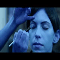

In [41]:
import random
random_test = random.choice(x_test)

predicted_class_name = ''
predicted_labels_probabilities = model.predict(np.expand_dims(random_test, axis = 0))[0]

# Get the index of class with highest probability.
predicted_label = np.argmax(predicted_labels_probabilities)

# Get the class name using the retrieved index.
predicted_class_name = class_list[predicted_label]

# Display the predicted action along with the prediction confidence.
print(f'Action Predicted: {predicted_class_name} Confidence: {predicted_labels_probabilities[predicted_label]} \n')

wxyz=0
for z in np.argsort(predicted_labels_probabilities)[::-1]:
        print(f"  {class_list[z]}: {predicted_labels_probabilities[z] * 100:5.2f}%")
        if wxyz ==4:
          break
        wxyz +=1

to_gif(np.array(random_test*255, dtype=np.float16))

1/1 [==============================] - 0s 48ms/step
Action Predicted: ['VolleyballSpiking'] Confidence: 0.9472008943557739 

  ['VolleyballSpiking']: 94.72%
  ['Swing']:  1.69%
  ['GolfSwing']:  0.63%
  ['Bowling']:  0.48%
  ['CleanAndJerk']:  0.35%



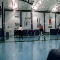

In [42]:
import random
random_test = random.choice(x_test)

predicted_class_name = ''
predicted_labels_probabilities = model.predict(np.expand_dims(random_test, axis = 0))[0]

# Get the index of class with highest probability.
predicted_label = np.argmax(predicted_labels_probabilities)

# Get the class name using the retrieved index.
predicted_class_name = class_list[predicted_label]

# Display the predicted action along with the prediction confidence.
print(f'Action Predicted: {predicted_class_name} Confidence: {predicted_labels_probabilities[predicted_label]} \n')

wxyz=0
for z in np.argsort(predicted_labels_probabilities)[::-1]:
        print(f"  {class_list[z]}: {predicted_labels_probabilities[z] * 100:5.2f}%")
        if wxyz ==4:
          break
        wxyz +=1

to_gif(np.array(random_test*255, dtype=np.float16))

1/1 [==============================] - 0s 48ms/step
Action Predicted: ['Knitting'] Confidence: 0.3174002170562744 

  ['Knitting']: 31.74%
  ['PizzaTossing']: 27.93%
  ['BoxingSpeedBag']: 22.74%
  ['Bowling']: 16.31%
  ['RockClimbingIndoor']:  0.83%



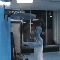

In [43]:
import random
random_test = random.choice(x_test)

predicted_class_name = ''
predicted_labels_probabilities = model.predict(np.expand_dims(random_test, axis = 0))[0]

# Get the index of class with highest probability.
predicted_label = np.argmax(predicted_labels_probabilities)

# Get the class name using the retrieved index.
predicted_class_name = class_list[predicted_label]

# Display the predicted action along with the prediction confidence.
print(f'Action Predicted: {predicted_class_name} Confidence: {predicted_labels_probabilities[predicted_label]} \n')

wxyz=0
for z in np.argsort(predicted_labels_probabilities)[::-1]:
        print(f"  {class_list[z]}: {predicted_labels_probabilities[z] * 100:5.2f}%")
        if wxyz ==4:
          break
        wxyz +=1

to_gif(np.array(random_test*255, dtype=np.float16))

1/1 [==============================] - 0s 50ms/step
Action Predicted: ['PizzaTossing'] Confidence: 0.9999699592590332 

  ['PizzaTossing']: 100.00%
  ['BabyCrawling']:  0.00%
  ['Punch']:  0.00%
  ['SkateBoarding']:  0.00%
  ['Haircut']:  0.00%



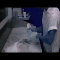

In [44]:
import random
random_test = random.choice(x_test)

predicted_class_name = ''
predicted_labels_probabilities = model.predict(np.expand_dims(random_test, axis = 0))[0]

# Get the index of class with highest probability.
predicted_label = np.argmax(predicted_labels_probabilities)

# Get the class name using the retrieved index.
predicted_class_name = class_list[predicted_label]

# Display the predicted action along with the prediction confidence.
print(f'Action Predicted: {predicted_class_name} Confidence: {predicted_labels_probabilities[predicted_label]} \n')

wxyz=0
for z in np.argsort(predicted_labels_probabilities)[::-1]:
        print(f"  {class_list[z]}: {predicted_labels_probabilities[z] * 100:5.2f}%")
        if wxyz ==4:
          break
        wxyz +=1

to_gif(np.array(random_test*255, dtype=np.float16))

1/1 [==============================] - 0s 46ms/step
Action Predicted: ['WallPushups'] Confidence: 0.9999991655349731 

  ['WallPushups']: 100.00%
  ['WritingOnBoard']:  0.00%
  ['TaiChi']:  0.00%
  ['BlowDryHair']:  0.00%
  ['JugglingBalls']:  0.00%



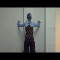

In [45]:
import random
random_test = random.choice(x_test)

predicted_class_name = ''
predicted_labels_probabilities = model.predict(np.expand_dims(random_test, axis = 0))[0]

# Get the index of class with highest probability.
predicted_label = np.argmax(predicted_labels_probabilities)

# Get the class name using the retrieved index.
predicted_class_name = class_list[predicted_label]

# Display the predicted action along with the prediction confidence.
print(f'Action Predicted: {predicted_class_name} Confidence: {predicted_labels_probabilities[predicted_label]} \n')

wxyz=0
for z in np.argsort(predicted_labels_probabilities)[::-1]:
        print(f"  {class_list[z]}: {predicted_labels_probabilities[z] * 100:5.2f}%")
        if wxyz ==4:
          break
        wxyz +=1

to_gif(np.array(random_test*255, dtype=np.float16))

1/1 [==============================] - 0s 48ms/step
Action Predicted: ['Skiing'] Confidence: 0.9999250173568726 

  ['Skiing']: 99.99%
  ['Rowing']:  0.01%
  ['Surfing']:  0.00%
  ['Kayaking']:  0.00%
  ['FrontCrawl']:  0.00%



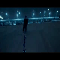

In [46]:
import random
random_test = random.choice(x_test)

predicted_class_name = ''
predicted_labels_probabilities = model.predict(np.expand_dims(random_test, axis = 0))[0]

# Get the index of class with highest probability.
predicted_label = np.argmax(predicted_labels_probabilities)

# Get the class name using the retrieved index.
predicted_class_name = class_list[predicted_label]

# Display the predicted action along with the prediction confidence.
print(f'Action Predicted: {predicted_class_name} Confidence: {predicted_labels_probabilities[predicted_label]} \n')

wxyz=0
for z in np.argsort(predicted_labels_probabilities)[::-1]:
        print(f"  {class_list[z]}: {predicted_labels_probabilities[z] * 100:5.2f}%")
        if wxyz ==4:
          break
        wxyz +=1

to_gif(np.array(random_test*255, dtype=np.float16))

1/1 [==============================] - 0s 49ms/step
Action Predicted: ['CleanAndJerk'] Confidence: 1.0 

  ['CleanAndJerk']: 100.00%
  ['SumoWrestling']:  0.00%
  ['ThrowDiscus']:  0.00%
  ['PizzaTossing']:  0.00%
  ['MilitaryParade']:  0.00%



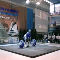

In [47]:
import random
random_test = random.choice(x_test)

predicted_class_name = ''
predicted_labels_probabilities = model.predict(np.expand_dims(random_test, axis = 0))[0]

# Get the index of class with highest probability.
predicted_label = np.argmax(predicted_labels_probabilities)

# Get the class name using the retrieved index.
predicted_class_name = class_list[predicted_label]

# Display the predicted action along with the prediction confidence.
print(f'Action Predicted: {predicted_class_name} Confidence: {predicted_labels_probabilities[predicted_label]} \n')

wxyz=0
for z in np.argsort(predicted_labels_probabilities)[::-1]:
        print(f"  {class_list[z]}: {predicted_labels_probabilities[z] * 100:5.2f}%")
        if wxyz ==4:
          break
        wxyz +=1

to_gif(np.array(random_test*255, dtype=np.float16))

1/1 [==============================] - 0s 49ms/step
Action Predicted: ['PlayingTabla'] Confidence: 0.9991521835327148 

  ['PlayingTabla']: 99.92%
  ['ShavingBeard']:  0.03%
  ['PlayingFlute']:  0.02%
  ['PullUps']:  0.02%
  ['PommelHorse']:  0.02%



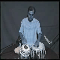

In [48]:
import random
random_test = random.choice(x_test)

predicted_class_name = ''
predicted_labels_probabilities = model.predict(np.expand_dims(random_test, axis = 0))[0]

# Get the index of class with highest probability.
predicted_label = np.argmax(predicted_labels_probabilities)

# Get the class name using the retrieved index.
predicted_class_name = class_list[predicted_label]

# Display the predicted action along with the prediction confidence.
print(f'Action Predicted: {predicted_class_name} Confidence: {predicted_labels_probabilities[predicted_label]} \n')

wxyz=0
for z in np.argsort(predicted_labels_probabilities)[::-1]:
        print(f"  {class_list[z]}: {predicted_labels_probabilities[z] * 100:5.2f}%")
        if wxyz ==4:
          break
        wxyz +=1

to_gif(np.array(random_test*255, dtype=np.float16))

1/1 [==============================] - 0s 48ms/step
Action Predicted: ['BaseballPitch'] Confidence: 0.9260284304618835 

  ['BaseballPitch']: 92.60%
  ['WalkingWithDog']:  6.27%
  ['TaiChi']:  0.44%
  ['SumoWrestling']:  0.35%
  ['HulaHoop']:  0.23%



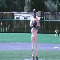

In [49]:
import random
random_test = random.choice(x_test)

predicted_class_name = ''
predicted_labels_probabilities = model.predict(np.expand_dims(random_test, axis = 0))[0]

# Get the index of class with highest probability.
predicted_label = np.argmax(predicted_labels_probabilities)

# Get the class name using the retrieved index.
predicted_class_name = class_list[predicted_label]

# Display the predicted action along with the prediction confidence.
print(f'Action Predicted: {predicted_class_name} Confidence: {predicted_labels_probabilities[predicted_label]} \n')

wxyz=0
for z in np.argsort(predicted_labels_probabilities)[::-1]:
        print(f"  {class_list[z]}: {predicted_labels_probabilities[z] * 100:5.2f}%")
        if wxyz ==4:
          break
        wxyz +=1

to_gif(np.array(random_test*255, dtype=np.float16))

1/1 [==============================] - 0s 49ms/step
Action Predicted: ['Basketball'] Confidence: 0.955135703086853 

  ['Basketball']: 95.51%
  ['Kayaking']:  4.45%
  ['Biking']:  0.02%
  ['TrampolineJumping']:  0.01%
  ['HorseRiding']:  0.00%



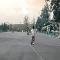

In [50]:
import random
random_test = random.choice(x_test)

predicted_class_name = ''
predicted_labels_probabilities = model.predict(np.expand_dims(random_test, axis = 0))[0]

# Get the index of class with highest probability.
predicted_label = np.argmax(predicted_labels_probabilities)

# Get the class name using the retrieved index.
predicted_class_name = class_list[predicted_label]

# Display the predicted action along with the prediction confidence.
print(f'Action Predicted: {predicted_class_name} Confidence: {predicted_labels_probabilities[predicted_label]} \n')

wxyz=0
for z in np.argsort(predicted_labels_probabilities)[::-1]:
        print(f"  {class_list[z]}: {predicted_labels_probabilities[z] * 100:5.2f}%")
        if wxyz ==4:
          break
        wxyz +=1

to_gif(np.array(random_test*255, dtype=np.float16))

1/1 [==============================] - 0s 51ms/step
Action Predicted: ['BaseballPitch'] Confidence: 0.9998598098754883 

  ['BaseballPitch']: 99.99%
  ['FloorGymnastics']:  0.01%
  ['ThrowDiscus']:  0.00%
  ['JavelinThrow']:  0.00%
  ['VolleyballSpiking']:  0.00%



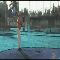

In [51]:
import random
random_test = random.choice(x_test)

predicted_class_name = ''
predicted_labels_probabilities = model.predict(np.expand_dims(random_test, axis = 0))[0]

# Get the index of class with highest probability.
predicted_label = np.argmax(predicted_labels_probabilities)

# Get the class name using the retrieved index.
predicted_class_name = class_list[predicted_label]

# Display the predicted action along with the prediction confidence.
print(f'Action Predicted: {predicted_class_name} Confidence: {predicted_labels_probabilities[predicted_label]} \n')

wxyz=0
for z in np.argsort(predicted_labels_probabilities)[::-1]:
        print(f"  {class_list[z]}: {predicted_labels_probabilities[z] * 100:5.2f}%")
        if wxyz ==4:
          break
        wxyz +=1

to_gif(np.array(random_test*255, dtype=np.float16))